# 1.0 Setup Path

In [1]:
import os

# os.chdir("../")

%pwd

'c:\\Users\\Hp\\Documents\\GitHub\\cattle-cvd-via-retina-imgs\\notebooks'

# 1.1 Import necessary Libraries

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# 1.2 Initialize Parameters

In [3]:
IMAGE_SIZE=255
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

directory_path = Path('../artifacts/dataset/retina_healthy_unhealthy')
directory_path

WindowsPath('../artifacts/dataset/retina_healthy_unhealthy')

# 1.3 Import Dataset

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1118 files belonging to 2 classes.


In [5]:
len(dataset)

35

# 1.4 Rename Classes

In [6]:
def rename_class_names(dataset, new_names):
    """
    Rename class names of a TensorFlow dataset.

    Args:
        dataset (tf.data.Dataset): The dataset whose class names need to be renamed.
        new_names (list): A list of new class names matching the order of original class names.

    Returns:
        dict: A mapping of old class names to new class names.
    """
    old_class_names = dataset.class_names
    if len(old_class_names) != len(new_names):
        raise ValueError("The number of new names must match the number of old class names.")
    
    # Create a mapping from old to new names
    name_mapping = dict(zip(old_class_names, new_names))
    
    # Update class names in the dataset (this is not persistent, used for reference)
    dataset.class_names = new_names  # Only for demonstration purposes, not supported directly in TensorFlow
    
    return name_mapping

# Example usage:
new_names = ['non-CVD', 'CVD']
class_name_mapping = rename_class_names(dataset, new_names)

print("Class name mapping:", class_name_mapping)
print("Updated class names:", dataset.class_names)

Class name mapping: {'0': 'non-CVD', '1': 'CVD'}
Updated class names: ['non-CVD', 'CVD']


In [7]:
class_names = dataset.class_names
class_names

['non-CVD', 'CVD']

# 1.5 Plot some of the Data

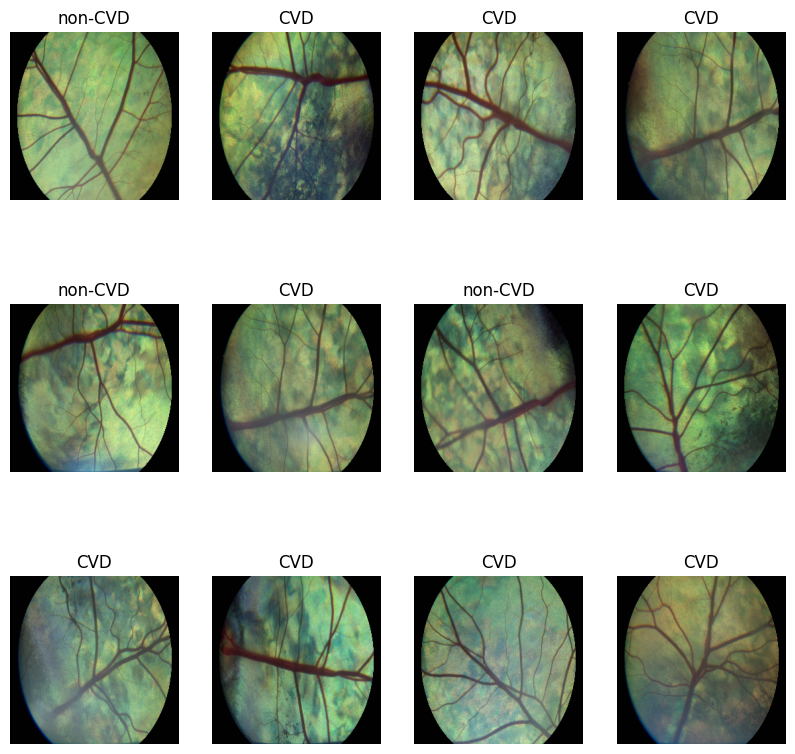

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# 1.6 Split Data

In [9]:
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.2, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size) 
    val_size = int(val_split*ds_size) 

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds  

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds), len(val_ds), len(test_ds))

28 3 4


In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# 2.0 Base model implementation

In [11]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, kernel_regularizer='l2', activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 255, 255, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 255, 255, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 253, 253, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 126, 126, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 124, 124, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 1)                │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,617 (717.25 KB)

 Trainable params: 183,617 (717.25 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5291 - loss: 0.6966 - val_accuracy: 0.5833 - val_loss: 0.6923
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 911ms/step - accuracy: 0.4998 - loss: 0.6933 - val_accuracy: 0.5833 - val_loss: 0.6918
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 883ms/step - accuracy: 0.5257 - loss: 0.6928 - val_accuracy: 0.5833 - val_loss: 0.6910
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 909ms/step - accuracy: 0.4918 - loss: 0.6934 - val_accuracy: 0.5833 - val_loss: 0.6890
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 854ms/step - accuracy: 0.5370 - loss: 0.6916 - val_accuracy: 0.5833 - val_loss: 0.6879
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 26s 923ms/step - accuracy: 0.5465 - loss: 0.6906 - val_accuracy: 0.5833 - val_loss: 0.6834
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 26s 928ms/step - accuracy: 0.5384 - loss: 0.6873 - val_accuracy: 0.6562 - val_loss: 0.6606
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5303 - loss: 0.6910 - val_accuracy: 

In [22]:
import time

# Function to save the model dynamically
def save_model(model, history, base_path='../artifacts/model/trials/', base_filename='CNN_model_v'):
    # Create the artifacts directory if it doesn't exist
    os.makedirs(base_path, exist_ok=True)
    
    # Generate a timestamp or use the history variable (like epoch number or loss)
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Use current timestamp for versioning
    version = f"{base_filename}_{timestamp}.keras"
    
    # Save the model
    model.save(os.path.join(base_path, version))
    print(f"Model saved as {version}")

save_model(model, history)

Model saved as CNN_model_v_20241225-220002.keras


# 3.0 Evaluation

In [23]:
from tensorflow.keras.models import load_model

def load_latest_model(base_path='../artifacts/model/trials/', base_filename='CNN_model_v'):
    # List all files in the directory
    files = os.listdir(base_path)
    
    # Filter for files that match the base filename and have the .keras extension
    model_files = [f for f in files if f.startswith(base_filename) and f.endswith('.keras')]
    
    if not model_files:
        raise FileNotFoundError("No model files found in the specified directory.")
    
    # Sort the model files by timestamp (i.e., by filename) in descending order
    model_files.sort(reverse=True)  # Most recent first based on filename
    
    # Load the most recent model
    latest_model_file = model_files[0]
    model = load_model(os.path.join(base_path, latest_model_file))
    
    print(f"Loaded model: {latest_model_file}")
    return model

model = load_latest_model()

Loaded model: CNN_model_v_20241225-220002.keras


In [ ]:
def evaluate_and_predict_model(model, test_ds):
    # Evaluate the model on the test dataset
    test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Predict on the test dataset
    y_pred_probs = model.predict(test_ds)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class predictions

    # Gather true labels from test_ds
    y_test = np.concatenate([y for x, y in test_ds], axis=0)

    # Print the classification report
    print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

evaluate_and_predict_model(model, test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.5281 - loss: 0.6917
Test Loss: 0.6899, Test Accuracy: 0.5469
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.45      1.00      0.62        58
           1       0.00      0.00      0.00        70

    accuracy                           0.45       128
   macro avg       0.23      0.50      0.31       128
weighted avg       0.21      0.45      0.28       128



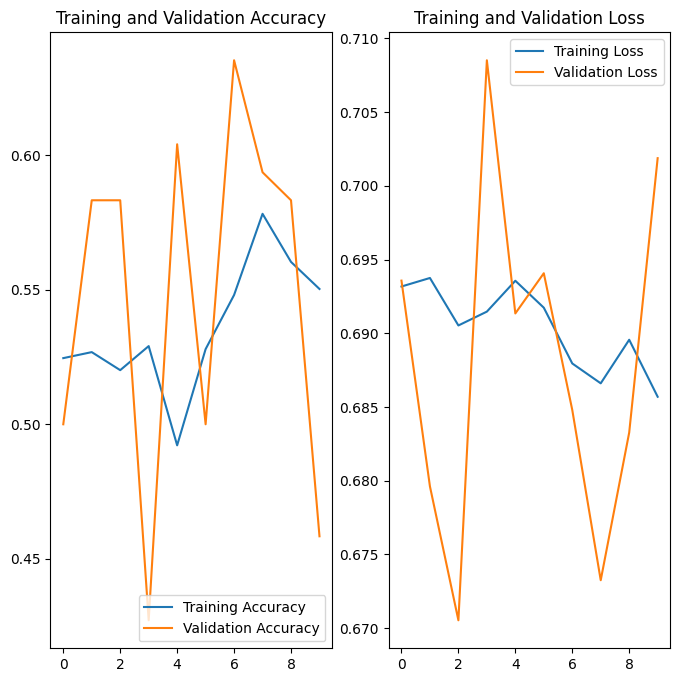

In [29]:
def plot_training_history(history, EPOCHS):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8,8))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(EPOCHS), acc, label='Training Accuracy')
    plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(range(EPOCHS), loss, label='Training Loss')
    plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_training_history(history, EPOCHS)